In [ ]:
import os
# Check if you're on Google drive or on your own machine.
# Get path to your data.
if ('google' in str(get_ipython())):
    from google.colab import drive
    drive.mount('ME', force_remount=True)
    predir='ME/MyDrive/Colab_Notebooks/thesis'

Mounted at ME


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
import pickle

from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# notebook variables

In [ ]:
groups = {
    'cat': ['nala_cat','realgrumpycat','smoothiethecat','catconworldwide','maple.cat','catinberlin','catladybox','triumphant_teagan','aliencatmatilda','mollymollzthetabby','my_lulu_cat_','my_furry_babies','monicasisson','allcreaturestv','moana.and.snapple','thatcatconrad','catsvscancer','baili_the_cat','panther.cat','rajathebengal','butter_the_siberian','trippy.tails','bearbear.cat','mochicat168','bellina_kitty_cat','rainerogers','ambrosepets','realbadgalrhirhi','pawaiihub','denbo_nish','siberian.milo'],
    'cook': ['halfbakedharvest','ketosnackz','nourishing','smittenkitchen','olivia.adriance','chloecleroux','geoffreyzakarian','177milkstreet','winnyhayes','alyssacoadynutrition','liveeatlearn','thefoodnanny','femalefoodie','sherryhour','allinspiredwellness','mytoddlerskitchen','simplicityandastarter','reciperunner','jamleenbears','lydialove98','mleroehler','anniesfinds_','carnivore_connoisseur_','littlespoonfarmblog','perfectsupplements','feelgoodwithfi','yourstrulyani','thismomentinthyme','leahmariestack','through.manals.lens','recipesfrommichelle','mccauley_tawpash','mintandclove','ashleighbovard','neeleman_food_'],
    # using lda
    'brands' : ['nike', 'adidas', 'starbucks', 'apple', 'samsung', 'netflix', 'amazon', 'google', 'microsoft', 'tesla', 'cocacola', 'pepsi', 'redbull', 'louisvuitton', 'gucci', 'chanel', 'prada', 'zara', 'hugo', 'hm', 'ikea', 'lego', 'target', 'walmart', 'mcdonalds', 'burgerking', 'kfc', 'dominos', 'airbnb', 'uber', 'spotify', 'youtube', 'facebook', 'instagram', 'twitter', 'pinterest', 'tiktok', 'snapchat', 'linkedin', 'sony', 'playstation', 'xbox', 'nintendo', 'disney', 'marvel', 'pixar', 'warnerbros', 'hbo', 'hulu', 'espn', 'nba', 'nfl', 'fifa', 'nikefootball', 'adidasfootball', 'puma', 'underarmour', 'reebok', 'converse', 'vans', 'forever21', 'victoriassecret', 'calvinklein', 'tommyhilfiger', 'ralphlauren', 'burberry', 'dior', 'versace', 'balenciaga', 'givenchy', 'fendi', 'hermes', 'cartier', 'tiffanyandco', 'rayban', 'oakley', 'gopro', 'canon', 'nikon', 'sonymusic', 'universalmusic', 'warnerrecords', 'atlanticrecords', 'rollingstone', 'vogue', 'elle', 'harpersbazaar', 'cosmopolitan'],
    # using deepseek
    'celebrities' : ['cristiano', 'leomessi', 'selenagomez', 'therock', 'kyliejenner', 'arianagrande', 'kimkardashian', 'beyonce', 'khloekardashian', 'justinbieber', 'kendalljenner', 'taylorswift', 'jlo', 'nickiminaj', 'kourtneykardash', 'mileycyrus', 'katyperry', 'zendaya', 'kevinhart4real', 'kingjames', 'ddlovato', 'badgalriri', 'champagnepapi', 'ellendegeneres', 'k.mbappe', 'billieeilish', 'lalalalisa_m', 'vindiesel', 'shraddhakapoor', 'priyankachopra', 'narendramodi', 'shakira', 'snoopdogg', 'davidbeckham', 'dualipa', 'jennierubyjane', 'aliaabhatt'],
    # using chatgpt
    'democrats' : ['joebiden', 'kamalaharris', 'barackobama', 'michelleobama', 'berniesanders', 'aoc', 'chuckSchumer', 'elizabethwarren', 'amyklobuchar', 'corybooker', 'chrismurphyct', 'repjerrynadler', 'repkatieporter', 'repvaldemings', 'repdebhaaland', 'repmarkpocan', 'repjimmygomez', 'repdavidcicilline', 'repdonbeyer', 'repderekkilmer', 'repsusielee', 'repkathleenrice', 'repjimhimes', 'repgregstanton', 'repjuanvargas', 'repmikethompson', 'repjimlangevin', 'repjimcosta', 'repjimmygomez', 'repjoshharder', 'repkatiehill'],
    'republicans' : ['mikepence', 'realdonaldtrump', 'potus', 'lindseygrahamsc', 'tedcruz', 'mittromney', 'pauldavisryan', 'ronjohnsonwi', 'marcorubio', 'newtgingrich', 'speakermccarthy', 'johncornyn', 'rondesantis', 'kristinoem', 'stevescalise', 'markmeadows', 'tx', 'elisestefanik', 'leezeldin', 'cathymcmorris', 'replizcheney', 'repmattgaetz', 'repbrianmast', 'repgregpence', 'repmarkgreen', 'repbuddycarter', 'repjeffduncan', 'repdavidkustoff', 'reppatfallon', 'repchrisstewart', 'repkenbuck'],
    # using deepseek

    'news': ['wsj', 'financialtimes', 'msnbc', 'cspan', 'theintercept', 'aljazeera', 'foxnews', 'guardian', 'time', 'nytimes', 'newsweek', 'bbcnews', 'bloomberg', 'nypost', 'businessinsider', 'cnn', 'forbes,politico', 'huffpost', 'abcnews', 'nbcnews', 'axios', 'thehill', 'cbsnews', 'usatoday', 'washingtonpost', 'vice', 'latimes', 'reuters', 'thedailybeast', 'npr', 'apnews'],

    'gun' : ['garand_thumb','gunpolicy','gunownersofamerica','sb.tactical','lawtactical','midwestindustries','centuryarms','gundrummer','griffin_armament','down_range_photography','maximdefense','zaffiri.precision','pewpewtactical','killerinnovations','rarebreedfirearms','battleborn','xtechtactical','gregskazphotography','kci_usa','firearmchronicles','patriot_defense_gear','704_tactical','armedscholaryt','shootersgrill','elevatedsilence','sdgunowners','womenforgunrights','gunownersca','2arally','rmgo_official'],
    # using lda

    'healthright' : ['thetruthaboutcancerttac','elaineshtein','drmercola','joshsfarmersmarket','dr.goodyear','crunchykass','raw_farm_usa','farmmatch','theregenaissance','momsacrossamerica','freedom.hill.farm','ilanamuhlsteinrd','jessalyn.randle','bobolinkdairyandbakehouse'],
    # using sbert

    'healthleft' : ['peoplescdc','clean.air.club','youlookokaytome','topheravila','thesicktimes','longcovidjustice','thaibrows','berlin_buyers_club','la.spoonie.collective','thecovidcollection','long_hauler_haven','maskednh','jaydocovid','maskblocseattle','cleartheair.atx','transgressivemedicine','itsjiyounkim'],

    # using sbert
    'queer' : ['them','themilesmckenna','queer_lective','dylanmulvaney','themme_fatale','chellaman','tanyacompas','mattxiv','sadegiliberti','jessicaoutofthecloset','genderlib','jake_graf5','raindovemodel','plussizetransguy','trans.ginger','trevorproject','chandlernwilson','blacktranstravelfund','mpjinstitute','gabesdunn'],

    'palestine' : ['jd.moha','mikopeled','wizard_bisan1','jewishvoiceforpeace','plestia.alaqad','belalkh','zein_rahma','eid_yara','lama_jamous9','jenanmatari','dr.ghassan.as','nooh.xp','savesilwan','amirgharabawi','saher_alghorra','haneen.maher.salem','palmuseum','yplusmedia','palestinianyouthmovement','right2edu','sjp.uo','uospalsoc','bigbigbigthings','jaxpsn','alaa_fayez.12','wizard_bisan2','bayanpalestine','mohammadhureini','hind.touissate','palestinehouseoffreedom','taniasafi','nadiforpalestine','queersinpalestine','apc_uk_london','shirien.creates','operationolivebranch'],
    'zionist' : ['betarworldwide','israelcc','standwithus','jewishwomen4allwomen','adielofisrael','ajc.global', 'strength4israel','_danielbraun','montanatucker','proudzionista','antisemitism','j.majburd','israel365action','bringhomenow','bring.amiram.home.now','aipac','kidnappedfromisrael','dahliakurtz','cameraoncampus','mactaskforce','elizabethyounger','lanianpo','henmazzig','freejamshidsharmahd','natashahausdorff','worldjewishcongress','allhostages','bringbackourhearts','thepersianjewess','michahdoot','leetrink','themodernmaccabee','ajewishresistance','zicksworld','abbasez'], # 'susancollinsla' not just israel

    'tradwife' : ['ourquaintandcozy','call_mejewels','hannahlee.yoder','simplyalliehomestead','ballerinafarm','esteecwilliams','zimcolorado','classicallyabby','naraaziza','lifewithmrsp', '_cynthialoewenseguin']
    # using sbert
}
groupmap = {v: k for k, vs in groups.items() for v in vs}
group_titles = {
    'cat': 'Cat',
    'cook': 'Cooking',
    'brands': 'Brands',
    'celebrities': 'Celebrities',
    'democrats': 'Democrats',
    'republicans': 'Republicans',
    'news': 'News',
    'gun': 'Gun',
    'healthright': 'Health Right',
    'healthleft': 'Health Left',
    'queer': 'LGBTQ',
    'palestine':'Pro-Palestine',
    'zionist': 'Zionist',
    'tradwife': 'Tradwives'
}
group_order = ['cat', 'cook', 'brands', 'celebrities', 'news','democrats', 'republicans', 'healthright', 'healthleft','gun', 'queer', 'tradwife','palestine', 'zionist']

finished_usernames = "thismomentinthyme,shraddhakapoor,trans.ginger,recipesfrommichelle,zaffiri.precision,reppatfallon,repdonbeyer,baili_the_cat,businessinsider,shootersgrill,trippy.tails,ambrosepets,classicallyabby,chellaman,ballerinafarm,patriot_defense_gear,mattxiv,bobolinkdairyandbakehouse,lindseygrahamsc,moana.and.snapple,instagram,mittromney,yplusmedia,arianagrande,_danielbraun,hind.touissate,plussizetransguy,selenagomez,through.manals.lens,repkenbuck,allinspiredwellness,jewishvoiceforpeace,taylorswift,pawaiihub,cspan,jaxpsn,repjerrynadler,mytoddlerskitchen,rarebreedfirearms,berniesanders,nooh.xp,xtechtactical,kevinhart4real,kamalaharris,repjuanvargas,catsvscancer,shakira,disney,themilesmckenna,taniasafi,repmarkpocan,itsjiyounkim,apc_uk_london,bigbigbigthings,rondesantis,target,reciperunner,chandlernwilson,palmuseum,repjimcosta,bayanpalestine,underarmour,nala_cat,bearbear.cat,repkathleenrice,liveeatlearn,barackobama,repjimhimes,aoc,repdebhaaland,cristiano,mcdonalds,lalalalisa_m,rmgo_official,smoothiethecat,tanyacompas,zendaya,louisvuitton,kimkardashian,calvinklein,victoriassecret,speakermccarthy,gabesdunn,queer_lective,montanatucker,down_range_photography,davidbeckham,belalkh,sdgunowners,repdavidkustoff,chrismurphyct,adidasfootball,winnyhayes,johncornyn,panther.cat,longcovidjustice,geoffreyzakarian,triumphant_teagan,blacktranstravelfund,ajewishresistance,nourishing,feelgoodwithfi,thetruthaboutcancerttac,israelcc,cartier,haneen.maher.salem,kourtneykardash,trevorproject,repbuddycarter,aliaabhatt,alaa_fayez.12,proudzionista,repjimlangevin,tedcruz,khloekardashian,transgressivemedicine,drmercola,pauldavisryan,michahdoot,repdavidcicilline,adielofisrael,freejamshidsharmahd,repkatieporter,sonymusic,repsusielee,leahmariestack,jake_graf5,microsoft,amirgharabawi,halfbakedharvest,billieeilish,femalefoodie,jlo,la.spoonie.collective,shirien.creates,mikepence,leezeldin,freedom.hill.farm,mpjinstitute,reuters,justinbieber,repbrianmast,lawtactical,704_tactical,ketosnackz,jessicaoutofthecloset,marcorubio,mccauley_tawpash,jennierubyjane,youlookokaytome,beyonce,gunownersofamerica,killerinnovations,elizabethyounger,right2edu,sadegiliberti,mleroehler,mintandclove,jd.moha,thaibrows,kyliejenner,them,esteecwilliams,starbucks,bloomberg,butter_the_siberian,my_furry_babies,pewpewtactical,farmmatch,alyssacoadynutrition,joebiden,repmarkgreen,priyankachopra,elevatedsilence,lydialove98,chloecleroux,amazon,thatcatconrad,narendramodi,hulu,aipac,kendalljenner,repgregpence,catconworldwide,badgalriri,uospalsoc,mikopeled,kristinoem,dylanmulvaney,dahliakurtz,champagnepapi,warnerrecords,repvaldemings,naraaziza,replizcheney,bellina_kitty_cat,repjoshharder,repchrisstewart,tommyhilfiger,neeleman_food_,aliencatmatilda,joshsfarmersmarket,raw_farm_usa,mohammadhureini,corybooker,plestia.alaqad,denbo_nish,wizard_bisan1,gundrummer,nickiminaj,kingjames,savesilwan,sb.tactical,ellendegeneres,antisemitism,gunownersca,topheravila,peoplescdc,rainerogers,repjimmygomez,abbasez,firearmchronicles,repkatiehill,mollymollzthetabby,anniesfinds_,lanianpo,zein_rahma,jessalyn.randle,call_mejewels,allcreaturestv,monicasisson,google,themme_fatale,maple.cat,perfectsupplements,kci_usa,nikefootball,mactaskforce,mochicat168,armedscholaryt,elaineshtein,kfc,chuckSchumer,leetrink,canon,catinberlin,battleborn,thefoodnanny,ourquaintandcozy,michelleobama,womenforgunrights,littlespoonfarmblog,zicksworld,olivia.adriance,leomessi,sherryhour,newtgingrich,elisestefanik,my_lulu_cat_,realgrumpycat,henmazzig,griffin_armament,_cynthialoewenseguin,repderekkilmer,centuryarms,lifewithmrsp,2arally,dr.goodyear,prada,eid_yara,ilanamuhlsteinrd,dominos,repjeffduncan,maximdefense,stevescalise,ashleighbovard,garand_thumb,k.mbappe,siberian.milo,nikon,cameraoncampus,realbadgalrhirhi,markmeadows,ronjohnsonwi,vice,raindovemodel,momsacrossamerica,repmattgaetz,repgregstanton,xbox,vindiesel,repmikethompson,katyperry,cathymcmorris,apple,therock,cosmopolitan,themodernmaccabee,pixar,ddlovato,worldjewishcongress,elizabethwarren,gopro,saher_alghorra,gunpolicy,catladybox,gregskazphotography,mileycyrus,midwestindustries,spotify,realdonaldtrump,yourstrulyani,amyklobuchar".split(",")

In [ ]:
with open(predir+'/data/df_bypost_all.pkl', 'rb') as f:
    df_bypost = pickle.load(f)

df_bypost = df_bypost.dropna(subset=['post_times']).query('likes > 0')[df_bypost['username'].isin(finished_usernames)]

# Extract cyclical time features
def fourier_encode(df):
    df['hour'] = df['post_times'].dt.hour
    df['day_of_week'] = df['post_times'].dt.dayofweek  # 0=Monday
    df['month'] = df['post_times'].dt.month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

data = fourier_encode(df_bypost)


# Time since last post (in hours)
data['timedelta'] = data['timedelta'].fillna(-1)  # First post

data['log_likes'] = np.log(data['likes']+1)

# Rolling average of likes (past 14 posts)
data['rolling_likes'] = (
    data.groupby('username')['log_likes']
    .transform(lambda x: x.shift(1).rolling(14, min_periods=1).mean())
)

# get the rate of change using np.gradient
data['deriv1'] = np.gradient(data['rolling_likes'])
data['deriv2'] = np.gradient(data['deriv1'])

data = data[data['date'] > pd.to_datetime('2023-01-01')]

<ipython-input-19-99d4461eff96>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_bypost = df_bypost.dropna(subset=['post_times']).query('likes > 0')[df_bypost['username'].isin(finished_usernames)]


In [ ]:
REACHBACK = 14
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model functions

In [ ]:
def df_to_traintest(df, PrepData):
  dataprepper = PrepData(df, reachback_length = REACHBACK)
  dataset = [x for x in dataprepper.get_dataset()]

  X, y = torch.cat([x[0] for x in dataset], dim=0), torch.tensor([x[1] for x in dataset])
  X = X.reshape(len(dataset), dataprepper.reachback_length*X.shape[1])

  torch.manual_seed(42)
  train, val = torch.utils.data.random_split(list(zip(X,y)), [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))])

  # print(f"Train size: {len(train)}")
  # print(f"Val size: {len(val)}")

  trainx, trainy = np.vstack([x[0] for x in train]), np.array([x[1] for x in train])
  valx, valy = np.vstack([x[0] for x in val]), np.array([x[1] for x in val])
  # testx, testy = np.vstack([x[0] for x in test]), np.array([x[1] for x in test])

  # Convert numpy arrays to PyTorch datasets
  train_dataset = torch.utils.data.TensorDataset(torch.tensor(trainx, dtype=torch.float32),
                                                torch.tensor(trainy, dtype=torch.float32))
  val_dataset = torch.utils.data.TensorDataset(torch.tensor(valx, dtype=torch.float32),
                                              torch.tensor(valy, dtype=torch.float32))

  # Create data loaders
  batch_size = 64
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=12)

  return train_loader, val_loader

def data_loader(df,PrepData, reachback_length=REACHBACK):
    dataprepper = PrepData(df, single_user=True, reachback_length=reachback_length)
    dataset = [x for x in dataprepper.get_dataset()]
    x, y = np.vstack([x[0] for x in dataset]), np.array([x[1] for x in dataset])
    x = x.reshape(len(dataset), dataprepper.reachback_length*x.shape[1])

    dataset = torch.utils.data.TensorDataset(torch.tensor(x, dtype=torch.float32),
                                             torch.tensor(y, dtype=torch.float32))
    batch_size = 64
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=12)
    return loader

In [ ]:
class TwoBranchPrepData():
    def __init__(self, df, reachback_length=REACHBACK,single_user=False):
        self.df = df
        self.reachback_length = reachback_length
        self.users = df['username'].unique()
        self.single_user = single_user

        # Precompute reachback
        self.reachback = []
        if self.single_user:
          for i in range(len(self.df) - (self.reachback_length)):
              seq = self.df.iloc[i:i+self.reachback_length]
              target = self.df.iloc[i+self.reachback_length]['likes']
              target = np.log(target+1)
              self.reachback.append((seq, target))
        else:
          for user in self.users:
              user_df = self.df[self.df['username'] == user]
              for i in range(len(user_df) - (self.reachback_length)):
                  seq = user_df.iloc[i:i+self.reachback_length]
                  target = user_df.iloc[i+self.reachback_length]['likes']
                  target = np.log(target+1)
                  self.reachback.append((seq, target))

    def __getitem__(self, idx):
        reachback, target = self.reachback[idx]

        # Text embeddings (reachback_length x 384)
        text_features = torch.tensor(
            np.stack(reachback['caption_embedding'].values),
            dtype=torch.float32
        )

        # Time features (reachback_length x 6)
        time_features = torch.tensor(
            reachback[['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']].values,
            dtype=torch.float32
        )

        # Historical features (reachback_length x 4)
        historical_features = torch.tensor(
            reachback[['rolling_likes', 'timedelta','deriv1','deriv2']].values,
            dtype=torch.float32
        )

        X = torch.cat([text_features, time_features, historical_features], dim=1)
        return X, target

    def get_dataset(self):
      if self.single_user:
          for i in range(len(self.reachback)):
              value = self.__getitem__(i)
              # check if there is any nan
              if value[0].isnan().any():
                  continue
              else:
                yield value
      else:
          for user in self.users:
              user_df = self.df[self.df['username'] == user]
              for i in range(len(user_df) - self.reachback_length):
                  value = self.__getitem__(i)
                  # check if there is any nan
                  if value[0].isnan().any():
                      continue
                  else:
                    yield value

class TwoBranchLikesPredictor(nn.Module):
    def __init__(self, sbert_dim=384, time_dim=6, historical_dim=4,
                 hidden_dim=64, reachback_length=REACHBACK,
                 verobose=False):
        super().__init__()
        self.reachback_length = reachback_length
        self.sbert_dim = sbert_dim
        self.time_dim = time_dim
        self.historical_dim = historical_dim

        self.verbose = verobose

        # Text processing
        self.text_fc = nn.Linear(sbert_dim, 128) # play with output dimension
        self.text_lstm = nn.LSTM(
            input_size=128,
            hidden_size=64,
            batch_first=True
        )

        # LSTM for temporal/historical patterns
        self.lstm = nn.LSTM(
            input_size=time_dim + historical_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )

        # Final prediction
        self.fc = nn.Sequential(
            nn.Linear(64 + hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # Reshape input: (batch_size, reachback_length * total_features) ->
        # (batch_size, reachback_length, total_features)
        x = x.view(-1, self.reachback_length, self.sbert_dim + self.time_dim + self.historical_dim)

        # Split features
        text_features = x[:, :, :self.sbert_dim]
        time_features = x[:, :, self.sbert_dim:self.sbert_dim+self.time_dim]
        historical_features = x[:, :, self.sbert_dim+self.time_dim:self.sbert_dim+self.time_dim + self.historical_dim]

        if self.verbose:
            print(f"Text features shape: {text_features.shape}")
            print(f"Time features shape: {time_features.shape}")
            print(f"Historical features shape: {historical_features.shape}")

        # Process text (batch_size, reachback_length, 128)
        text_emb = self.text_fc(text_features)
        text_lstm = self.text_lstm(text_emb)
        text_last = text_lstm[0][:, -1, :]  # Last timestep
        # text_agg = torch.mean(text_emb, dim=1)  # Average over sequence

        if self.verbose:
            print(f"text fc: {text_emb.shape}")
            print(f"Text agg shape: {text_last.shape}")

        # Process temporal features (batch_size, reachback_length, 6)
        temporal_input = torch.cat([time_features, historical_features], dim=2)
        lstm_out, _ = self.lstm(temporal_input)
        lstm_last = lstm_out[:, -1, :]  # Last timestep

        if self.verbose:
            print(f"LSTM output shape: {lstm_last.shape}")

        # Combine features
        combined = torch.cat([text_last, lstm_last], dim=1)

        if self.verbose:
            print(f"Combined shape: {combined.shape}")

        return self.fc(combined)

In [ ]:
def train_model(model, train_loader, val_loader, lr=0.001, num_epochs= 10, verbose = False):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  train_loss_history = []
  val_loss_history = []
  for epoch in tqdm(range(num_epochs)):
      # Training phase
      model.train()
      train_loss = 0.0
      for inputs, targets in train_loader:
          inputs = inputs.to(device)
          targets = targets.to(device).float()
          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs.squeeze(), targets)
          loss.backward()
          optimizer.step()

          train_loss += loss.item() * inputs.size(0)

      # Calculate average training loss
      train_loss = train_loss / len(train_loader.dataset)

      # Validation phase
      model.eval()
      val_loss = 0.0
      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs = inputs.to(device)
              targets = targets.to(device).float()
              outputs = model(inputs)
              loss = criterion(outputs.squeeze(), targets)
              val_loss += loss.item() * inputs.size(0)

      val_loss = val_loss / len(val_loader.dataset)

      train_loss_history.append(train_loss)
      val_loss_history.append(val_loss)

      if verbose:
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        print('-' * 50)
  return model, train_loss_history, val_loss_history

def test_model(model, test_loader):
  criterion = nn.MSELoss()
  model.eval()
  test_loss = 0.0
  test_loss_unlog = 0.0
  with torch.no_grad():
      for inputs, targets in test_loader:
          outputs = model(inputs)
          loss = criterion(outputs.squeeze(), targets)
          test_loss += loss.item() * inputs.size(0)

          outputs_unlog = torch.exp(outputs)
          targets_unlog = torch.exp(targets)
          loss_unlog = criterion(outputs_unlog.squeeze(), targets_unlog)
          test_loss_unlog += loss_unlog.item() * inputs.size(0)

  test_loss = test_loss / len(test_loader.dataset)
  test_loss_unlog = test_loss_unlog / len(test_loader.dataset)

  return test_loss, test_loss_unlog

# palestine / israel

In [ ]:
date_policy1 = pd.to_datetime('2024-02-09')
earliest_before = pd.to_datetime('2023-10-01')

before_dates = pd.date_range(start=earliest_before - pd.Timedelta(days=1), end=date_policy1 - pd.Timedelta(days=14), freq='1ME') + pd.Timedelta(days=1)
len(before_dates), before_dates

(4,
 DatetimeIndex(['2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01'], dtype='datetime64[ns]', freq=None))

### getting residuals

In [ ]:
data_loaders1 = dict()

data_after = data[data['date'] >= date_policy1]
for group in tqdm(group_order):
  data_loaders1[group] = dict()
  data_after_group = data_after[data_after['group'] == group]

  data_group = data[data['group'] == group]
  for before in before_dates:
    data_before_group = data_group[data_group['date'] < before]
    if len(data_before_group) < 100:
      print(f"Not enough data for {group} before {before}")
      data_loaders1[group][before] = None
    else:
      train_loader, val_loader = df_to_traintest(data_before_group, TwoBranchPrepData)
      after_loader = data_loader(data_after_group, TwoBranchPrepData)
      data_loaders1[group][before] = (train_loader, val_loader, after_loader)

100%|██████████| 14/14 [13:44<00:00, 58.88s/it]


In [ ]:
# # save data_loaders1
# with open(f'{predir}/dataloaders/data_loaders1.pkl', 'wb') as f:
#     pickle.dump(data_loaders1, f)

In [ ]:
# with open(f'{predir}/dataloaders/data_loaders1.pkl', 'rb') as f:
#     data_loaders1 = pickle.load(f)

In [ ]:
models1  = dict()

for group in group_order:
  print(f"Training {group}" + "-"*30)
  models1[group] = dict()
  for before in before_dates:
    if data_loaders1[group][before] is not None:
      train_loader, val_loader, after_loader = data_loaders1[group][before]

      model = TwoBranchLikesPredictor(
          sbert_dim = 384, reachback_length=REACHBACK
      ).to(device)

      model, train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, lr=0.001, num_epochs= 20, verbose = False)

      models1[group][before] = (model, train_loss_history, val_loss_history)
    else:
      models1[group][before] = None
      print(f"Not enough data for {group}")

In [ ]:
import os
# save models
for group in group_order:
  for before in before_dates:
    if models1[group][before] is not None:
      model, train_loss_history, val_loss_history = models1[group][before]
      before_string = before.strftime('%Y-%m-%d')
      torch.save(model.state_dict(), f'{predir}/models/set2/{group}_{before_string}.pt')

# for group, (model, train_loss_history, val_loss_history) in models1.items():
#   torch.save(model.state_dict(), f'{predir}/models/feb2024/{group}.pt')

In [ ]:
loaded_models1 = {}
for group in tqdm(group_order):
    loaded_models1[group] = {}
    for before in before_dates:
        before_string = before.strftime('%Y-%m-%d')
        model_path = f'{predir}/models/set2/{group}_{before_string}.pt'
        if os.path.exists(model_path):
            model = TwoBranchLikesPredictor(sbert_dim=384, reachback_length=REACHBACK).to(device)
            model.load_state_dict(torch.load(model_path))
            model.eval()  # Set the model to evaluation mode
            loaded_models1[group][before] = model
        else:
            print(f"Model file not found for {group} before {before_string}")
            loaded_models1[group][before] = None

In [ ]:
residuals1 = dict()

for group in tqdm(group_order):
  print(f"Residuals for {group}" + "-"*30)
  residuals1[group] = dict()
  for before in before_dates:
    model = loaded_models1[group][before]
    data_before = data[data['group'] == group]
    data_before = data_before[data_before['date'] < before]

    dataloader_before = data_loader(data_before.query(f'group == "{group}"'), TwoBranchPrepData)
    if data_loaders1[group][before] is not None:
      train_loader, val_loader, after_loader = data_loaders1[group][before]
      model.eval()

      residuals_before, residuals_after, residuals_train, residuals_val = [], [], [], []

      with torch.no_grad():
          for inputs, targets in dataloader_before:
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = model(inputs)
              residuals_before.extend(targets - outputs.squeeze())

      with torch.no_grad():
          for inputs, targets in after_loader:
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = model(inputs)
              residuals_after.extend(targets - outputs.squeeze())

      # with torch.no_grad():
      #     for inputs, targets in train_loader:
      #         inputs, targets = inputs.to(device), targets.to(device)
      #         outputs = model(inputs)
      #         residuals_train.extend(targets - outputs.squeeze())

      # with torch.no_grad():
      #     for inputs, targets in val_loader:
      #         inputs, targets = inputs.to(device), targets.to(device)
      #         outputs = model(inputs)
      #         residuals_val.extend(targets - outputs.squeeze())
      residuals_train = None
      residuals_val = None

      residuals1[group][before] = (residuals_before, residuals_after, residuals_train, residuals_val)
    else:
      residuals1[group][before] = None
      print(f"Not enough data for {group}")

  0%|          | 0/14 [00:00<?, ?it/s]

Residuals for cat------------------------------


  7%|▋         | 1/14 [01:03<13:43, 63.35s/it]

Residuals for cook------------------------------


 14%|█▍        | 2/14 [02:16<13:49, 69.10s/it]

Residuals for brands------------------------------


 21%|██▏       | 3/14 [04:25<17:40, 96.40s/it]

Residuals for celebrities------------------------------


 29%|██▊       | 4/14 [05:39<14:34, 87.49s/it]

Residuals for democrats------------------------------


 36%|███▌      | 5/14 [06:52<12:21, 82.41s/it]

Residuals for republicans------------------------------


 43%|████▎     | 6/14 [08:08<10:40, 80.07s/it]

Residuals for news------------------------------


 50%|█████     | 7/14 [09:05<08:29, 72.77s/it]

Residuals for healthright------------------------------


 57%|█████▋    | 8/14 [10:04<06:49, 68.24s/it]

Residuals for healthleft------------------------------


 64%|██████▍   | 9/14 [10:47<05:01, 60.40s/it]

Residuals for queer------------------------------


 71%|███████▏  | 10/14 [11:49<04:03, 60.98s/it]

Residuals for gun------------------------------


 79%|███████▊  | 11/14 [13:17<03:27, 69.20s/it]

Residuals for tradwife------------------------------


 86%|████████▌ | 12/14 [14:02<02:03, 61.79s/it]

Residuals for palestine------------------------------


 93%|█████████▎| 13/14 [15:02<01:01, 61.24s/it]

Residuals for zionist------------------------------


100%|██████████| 14/14 [16:15<00:00, 69.67s/it]


In [ ]:
# send to cpu
for group in group_order:
  for before in before_dates:
    if residuals1[group][before] is not None:
      residuals_before, residuals_after, residuals_train, residuals_val = residuals1[group][before]
      residuals_before = [x.cpu().numpy() for x in residuals_before]
      residuals_after = [x.cpu().numpy() for x in residuals_after]
      # residuals_train = [x.cpu().numpy() for x in residuals_train]
      # residuals_val = [x.cpu().numpy() for x in residuals_val]

      residuals1[group][before] = (residuals_before, residuals_after, residuals_train, residuals_val)

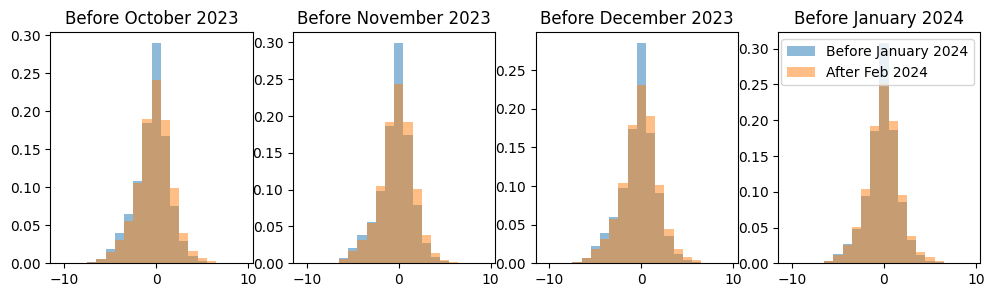

In [ ]:
# compare all residuals of a group across before_dates
all_residuals_before = dict()
all_residuals_after = dict()
for group in group_order:
  for before in before_dates:
    if before in all_residuals_before.keys():
      all_residuals_before[before].extend(residuals1[group][before][0])
      all_residuals_after[before].extend(residuals1[group][before][1])
    else:
      all_residuals_before[before] = residuals1[group][before][0]
      all_residuals_after[before] = residuals1[group][before][1]

plt.figure(figsize=(12,3))
for i,before in enumerate(all_residuals_before.keys()):
  before_residuals, after_residuals = all_residuals_before[before], all_residuals_after[before]
  plt.subplot(1, 4, i+1)
  plt.hist(before_residuals, alpha = 0.5 ,density=True, label = f'Before {before.strftime("%B %Y")}', bins = np.arange(-10.5,10.5,1))
  plt.hist(after_residuals, alpha = 0.5 ,density=True, label = 'After Feb 2024', bins = np.arange(-10.5,10.5,1))
  plt.title(f'Before {before.strftime("%B %Y")}')
plt.legend()


### residuals analysis

In [ ]:
# with open(f'{predir}/residuals/residuals1.pkl', 'wb') as f:
    # pickle.dump(residuals1, f)

with open(f'{predir}/residuals/residuals1.pkl', 'rb') as f:
    residuals1 = pickle.load(f)


In [ ]:
# t-test on averages before and after
from scipy.stats import ttest_ind
from scipy.stats import permutation_test
from datetime import timedelta

df_ttest = pd.DataFrame(columns=['group','before','tstat','pval','residual'])

for group in group_order:
  for before in before_dates:
    before_residuals, after_residuals = residuals1[group][before][0], residuals1[group][before][1]

    ttest = ttest_ind(before_residuals, after_residuals)
    # interval = ttest.confidence_interval()
    df_ttest = pd.concat([df_ttest, pd.DataFrame({'group': [group], 'before': [before], 'tstat': [ttest[0]], 'pval': [ttest[1]], 'residual':True})])

    before_ll = data[data['date'] < before].query('group == @group')['log_likes']
    after_ll = data[data['date'] >= date_policy1].query('group == @group')['log_likes']

    ttest = ttest_ind(before_ll, after_ll)

    df_ttest = pd.concat([df_ttest, pd.DataFrame({'group': [group], 'before': [before], 'tstat': [ttest[0]], 'pval': [ttest[1]], 'residual':False})])

df_ttest['signif'] = (df_ttest['pval'] * 14) < 0.05 # bonferroni correction

<ipython-input-36-60e41f1a3437>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ttest = pd.concat([df_ttest, pd.DataFrame({'group': [group], 'before': [before], 'tstat': [ttest[0]], 'pval': [ttest[1]], 'residual':True})])


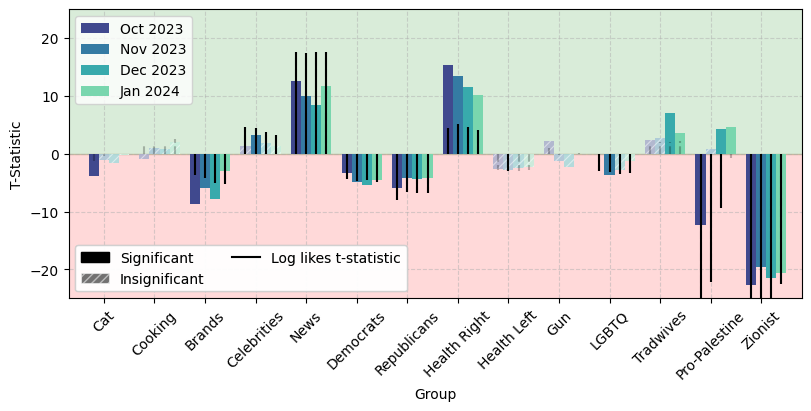

In [ ]:
# make a grouped barchart with different colors for different 'before'


x = np.arange(len(group_order))
width = 0.2
multiplier = 0

# make colormap from seaborn rocket
colors = sns.color_palette("mako", len(before_dates)+1)[1:]

fig, ax = plt.subplots(layout='constrained', figsize = (8,4))
for color, before in zip(colors, before_dates):
  offset = width * multiplier
  df_before = df_ttest[df_ttest['before'] == before]
  df_residual = df_before[df_before['residual'] == True].copy()
  df_ll = df_before[df_before['residual'] == False].copy()

  # rects = ax.bar(x + offset, df_ll['tstat'], 0.05, color='black', alpha = 0.75, zorder = 4)
  # change to vlines
  ax.vlines(x + offset, ymin=0, ymax=df_ll['tstat'], color='black', alpha = 0.25, zorder = 4, linestyles='dashed')

  # rects = ax.bar(x + offset, df_ll['tstat'], 0.05, edgecolor='white', color = 'white', hatch = '////', alpha = 0.5, hatch_linewidth = 2, zorder = 4, linewidth = 0)
  # get tstat if significant, otherwise 0
  df_ll['signif_values'] = np.where(df_ll['signif'], df_ll['tstat'], 0)
  # rects = ax.bar(x + offset, df_ll['signif_values'], 0.05, color='black', zorder = 4)
  ax.vlines(x + offset, ymin=0, ymax=df_ll['signif_values'], color='black', zorder = 4)


  rects = ax.bar(x + offset, df_residual['tstat'], width, color=color, alpha = 0.75, zorder = 3)
  rects = ax.bar(x + offset, df_residual['tstat'], width, edgecolor='white', color = 'white', hatch = '////', alpha = 0.5, hatch_linewidth = 0.8, zorder = 3, linewidth = 0)
  # get tstat if significant, otherwise 0
  df_residual['signif_values'] = np.where(df_residual['signif'], df_residual['tstat'], 0)
  rects = ax.bar(x + offset, df_residual['signif_values'], width, color=color, zorder = 3, label=before.strftime("%b %Y"))
  # ax.bar_label(rects, padding=3)
  multiplier += 1

ax.fill_betweenx([-100,0], -100, 100, color='red', alpha=0.15, zorder = 1)
ax.fill_betweenx([0,100], -100, 100, color='green', alpha=0.15, zorder = 1)

ax.set_ylabel('t-statistic')
ax.set_xticks(x + width, [group_titles[x] for x in group_order], rotation = 45)

# set ylim
ax.set_ylim(-25,25)
ax.set_xlim([-0.5,len(group_order)])

# add black square labeled "significant" and black with alpha = 0 and white hatches as "insignificant"
black_patch = mpatches.Patch(color='black', label = 'Significant')
white_patch = mpatches.Patch(color='black', label = 'Insignificant', alpha = 0.5)
white_patch.update({'hatch': '////', 'edgecolor': 'white', 'linewidth': 0.8})
# make black line
black_line = mlines.Line2D([], [], color='black', label='Log likes t-statistic')

# make separate legend for significant insignificant
handles, labels = ax.get_legend_handles_labels()
l1 = ax.legend(handles, labels, loc = 2)
l2 = ax.legend(handles=[black_patch, white_patch, black_line], labels=['Significant', 'Insignificant','Log likes t-statistic'], loc=3, ncols=2)
ax.add_artist(l1)
ax.add_artist(l2)


# add grid
ax.grid(alpha=0.5, linestyle='--', zorder = 0)

ax.set_xlabel('Group')
ax.set_ylabel('T-Statistic')

plt.savefig(predir+'/figs/ttest_split1.png',bbox_inches='tight', dpi = 800)

# trump inaug

In [ ]:
date_policy2 = pd.to_datetime('2025-01-07')
earliest_before = pd.to_datetime('2024-09-01')

before_dates = pd.date_range(start=earliest_before - pd.Timedelta(days=1), end=date_policy2 - pd.Timedelta(days=14), freq='1ME') + pd.Timedelta(days=1)
len(before_dates), before_dates

(4,
 DatetimeIndex(['2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01'], dtype='datetime64[ns]', freq=None))

### getting residuals

In [ ]:
data_loaders2 = dict()

data_after = data[data['date'] >= date_policy2]
for group in tqdm(group_order):
  data_loaders2[group] = dict()
  data_after_group = data_after[data_after['group'] == group]

  data_group = data[data['group'] == group]
  for before in before_dates:
    data_before_group = data_group[data_group['date'] < before]
    if len(data_before_group) < 100:
      print(f"Not enough data for {group} before {before}")
      data_loaders2[group][before] = None
    else:
      train_loader, val_loader = df_to_traintest(data_before_group, TwoBranchPrepData)
      after_loader = data_loader(data_after_group, TwoBranchPrepData)
      data_loaders2[group][before] = (train_loader, val_loader, after_loader)

100%|██████████| 14/14 [13:09<00:00, 56.42s/it]


In [ ]:
# save data_loaders1
with open(f'{predir}/dataloaders/data_loaders2.pkl', 'wb') as f:
    pickle.dump(data_loaders2, f)

In [ ]:
with open(f'{predir}/data_loaders2.pkl', 'rb') as f:
    data_loaders2_saved = pickle.load(f)

In [ ]:
models2  = dict()

for group in group_order:
  print(f"Training {group}" + "-"*30)
  models2[group] = dict()
  for before in before_dates:
    if data_loaders2[group][before] is not None:
      train_loader, val_loader, after_loader = data_loaders2[group][before]

      model = TwoBranchLikesPredictor(
          sbert_dim = 384, reachback_length=REACHBACK
      ).to(device)

      model, train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, lr=0.001, num_epochs= 20, verbose = False)

      models2[group][before] = (model, train_loss_history, val_loss_history)
    else:
      models2[group][before] = None
      print(f"Not enough data for {group}")

Training cat------------------------------


100%|██████████| 20/20 [03:41<00:00, 11.05s/it]


Training cook------------------------------


100%|██████████| 20/20 [03:47<00:00, 11.37s/it]


Training brands------------------------------


100%|██████████| 20/20 [04:23<00:00, 13.20s/it]


Training celebrities------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 20/20 [03:50<00:00, 11.54s/it]


Training democrats------------------------------


100%|██████████| 20/20 [03:53<00:00, 11.68s/it]


Training republicans------------------------------


100%|██████████| 20/20 [03:56<00:00, 11.82s/it]


Training news------------------------------


100%|██████████| 20/20 [03:45<00:00, 11.26s/it]


Training healthright------------------------------


100%|██████████| 20/20 [03:45<00:00, 11.29s/it]


Training healthleft------------------------------


100%|██████████| 20/20 [03:32<00:00, 10.61s/it]


Training queer------------------------------


100%|██████████| 20/20 [03:51<00:00, 11.56s/it]


Training gun------------------------------


100%|██████████| 20/20 [04:04<00:00, 12.21s/it]


Training tradwife------------------------------


100%|██████████| 20/20 [03:36<00:00, 10.83s/it]


Training palestine------------------------------


100%|██████████| 20/20 [03:56<00:00, 11.81s/it]


Training zionist------------------------------


100%|██████████| 20/20 [04:14<00:00, 12.74s/it]


In [ ]:
import os
# save models
for group in group_order:
  for before in before_dates:
    if models2[group][before] is not None:
      model, train_loss_history, val_loss_history = models2[group][before]
      before_string = before.strftime('%Y-%m-%d')
      torch.save(model.state_dict(), f'{predir}/models/set2_jan/{group}_{before_string}.pt')

# for group, (model, train_loss_history, val_loss_history) in models1.items():
#   torch.save(model.state_dict(), f'{predir}/models/feb2024/{group}.pt')

In [ ]:
loaded_models = {}
for group in tqdm(group_order):
    loaded_models[group] = {}
    for before in before_dates:
        before_string = before.strftime('%Y-%m-%d')
        model_path = f'{predir}/models/set2_jan/{group}_{before_string}.pt'
        if os.path.exists(model_path):
            model = TwoBranchLikesPredictor(sbert_dim=384, reachback_length=REACHBACK).to(device)
            model.load_state_dict(torch.load(model_path))
            model.eval()  # Set the model to evaluation mode
            loaded_models[group][before] = model
        else:
            print(f"Model file not found for {group} before {before_string}")
            loaded_models[group][before] = None

In [ ]:
residuals2 = dict()

for group in tqdm(group_order):
  print(f"Residuals for {group}" + "-"*30)
  residuals2[group] = dict()
  for before in before_dates:
    model = loaded_models[group][before]
    data_before = data[data['group'] == group]
    data_before = data_before[data_before['date'] < before]

    dataloader_before = data_loader(data_before.query(f'group == "{group}"'), TwoBranchPrepData)
    if data_loaders2[group][before] is not None:
      train_loader, val_loader, after_loader = data_loaders2[group][before]
      model.eval()

      residuals_before, residuals_after, residuals_train, residuals_val = [], [], [], []

      with torch.no_grad():
          for inputs, targets in dataloader_before:
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = model(inputs)
              residuals_before.extend(targets - outputs.squeeze())

      with torch.no_grad():
          for inputs, targets in after_loader:
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = model(inputs)
              residuals_after.extend(targets - outputs.squeeze())

      with torch.no_grad():
          for inputs, targets in train_loader:
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = model(inputs)
              residuals_train.extend(targets - outputs.squeeze())

      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = model(inputs)
              residuals_val.extend(targets - outputs.squeeze())

      residuals2[group][before] = (residuals_before, residuals_after, residuals_train, residuals_val)
    else:
      residuals2[group][before] = None
      print(f"Not enough data for {group}")

  0%|          | 0/14 [00:00<?, ?it/s]

Residuals for cat------------------------------


  7%|▋         | 1/14 [01:28<19:12, 88.62s/it]

Residuals for cook------------------------------


 14%|█▍        | 2/14 [03:14<19:42, 98.51s/it]

Residuals for brands------------------------------


 21%|██▏       | 3/14 [06:50<27:57, 152.45s/it]

Residuals for celebrities------------------------------


 29%|██▊       | 4/14 [08:45<22:56, 137.64s/it]

Residuals for democrats------------------------------


 36%|███▌      | 5/14 [10:40<19:23, 129.25s/it]

Residuals for republicans------------------------------


 43%|████▎     | 6/14 [12:39<16:47, 125.97s/it]

Residuals for news------------------------------


 50%|█████     | 7/14 [14:00<12:57, 111.08s/it]

Residuals for healthright------------------------------


 57%|█████▋    | 8/14 [15:24<10:14, 102.49s/it]

Residuals for healthleft------------------------------


 64%|██████▍   | 9/14 [16:17<07:15, 87.10s/it] 

Residuals for queer------------------------------


 71%|███████▏  | 10/14 [17:55<06:01, 90.46s/it]

Residuals for gun------------------------------


 79%|███████▊  | 11/14 [20:11<05:13, 104.54s/it]

Residuals for tradwife------------------------------


 86%|████████▌ | 12/14 [21:08<02:59, 89.95s/it] 

Residuals for palestine------------------------------


 93%|█████████▎| 13/14 [22:55<01:35, 95.10s/it]

Residuals for zionist------------------------------


100%|██████████| 14/14 [25:38<00:00, 109.93s/it]


In [ ]:
# send to cpu
for group in group_order:
  for before in before_dates:
    if residuals2[group][before] is not None:
      residuals_before, residuals_after, residuals_train, residuals_val = residuals2[group][before]
      residuals_before = [x.cpu().numpy() for x in residuals_before]
      residuals_after = [x.cpu().numpy() for x in residuals_after]
      residuals_train = [x.cpu().numpy() for x in residuals_train]
      residuals_val = [x.cpu().numpy() for x in residuals_val]

      residuals2[group][before] = (residuals_before, residuals_after, residuals_train, residuals_val)

In [ ]:
with open(f'{predir}/residuals/residuals2.pkl', 'wb') as f:
    pickle.dump(residuals2, f)

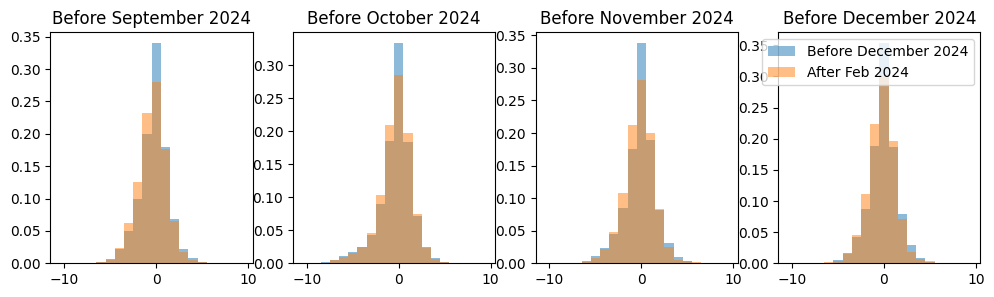

In [ ]:
# compare all residuals of a group across before_dates
all_residuals_before = dict()
all_residuals_after = dict()
for group in group_order:
  for before in before_dates:
    if before in all_residuals_before.keys():
      all_residuals_before[before].extend(residuals2[group][before][0])
      all_residuals_after[before].extend(residuals2[group][before][1])
    else:
      all_residuals_before[before] = residuals2[group][before][0]
      all_residuals_after[before] = residuals2[group][before][1]

plt.figure(figsize=(12,3))
for i,before in enumerate(all_residuals_before.keys()):
  before_residuals, after_residuals = all_residuals_before[before], all_residuals_after[before]
  # before_residuals = [x.cpu().numpy() for x in before_residuals]
  # after_residuals = [x.cpu().numpy() for x in after_residuals]
  plt.subplot(1, 4, i+1)
  plt.hist(before_residuals, alpha = 0.5 ,density=True, label = f'Before {before.strftime("%B %Y")}', bins = np.arange(-10.5,10.5,1))
  plt.hist(after_residuals, alpha = 0.5 ,density=True, label = 'After Feb 2024', bins = np.arange(-10.5,10.5,1))
  plt.title(f'Before {before.strftime("%B %Y")}')
plt.legend()


### residuals analysis

In [ ]:
with open(f'{predir}/residuals/residuals2.pkl', 'rb') as f:
    residuals2 = pickle.load(f)

In [ ]:
# t-test on averages before and after
from scipy.stats import ttest_ind
from scipy.stats import permutation_test
from datetime import timedelta

df_ttest = pd.DataFrame(columns=['group','before','tstat','pval','residual'])

for group in group_order:
  for before in before_dates:
    before_residuals, after_residuals = residuals2[group][before][0], residuals2[group][before][1]

    ttest = ttest_ind(before_residuals, after_residuals)
    # interval = ttest.confidence_interval()
    df_ttest = pd.concat([df_ttest, pd.DataFrame({'group': [group], 'before': [before], 'tstat': [ttest[0]], 'pval': [ttest[1]], 'residual':True})])

    before_ll = data[data['date'] < before].query('group == @group')['log_likes']
    after_ll = data[data['date'] >= date_policy1].query('group == @group')['log_likes']

    ttest = ttest_ind(before_ll, after_ll)

    df_ttest = pd.concat([df_ttest, pd.DataFrame({'group': [group], 'before': [before], 'tstat': [ttest[0]], 'pval': [ttest[1]], 'residual':False})])

df_ttest['signif'] = (df_ttest['pval'] * 14) < 0.05 # bonferroni correction

<ipython-input-61-9a4f7414225c>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ttest = pd.concat([df_ttest, pd.DataFrame({'group': [group], 'before': [before], 'tstat': [ttest[0]], 'pval': [ttest[1]], 'residual':True})])


Text(0, 0.5, 'T-Statistic')

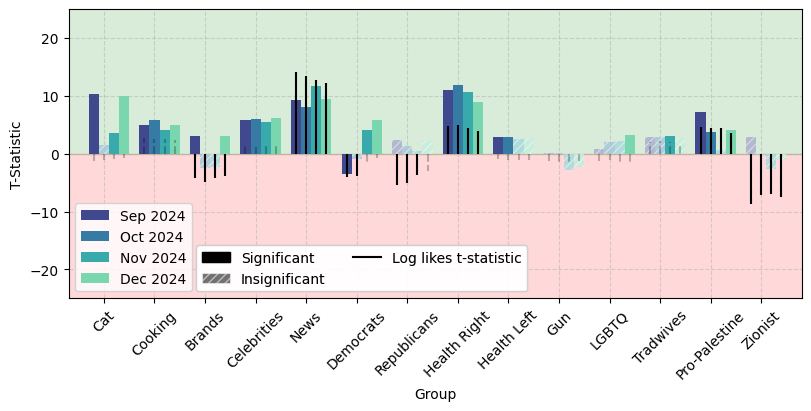

In [ ]:
# make a grouped barchart with different colors for different 'before'


x = np.arange(len(group_order))
width = 0.2
multiplier = 0

# make colormap from seaborn rocket
colors = sns.color_palette("mako", len(before_dates)+1)[1:]

fig, ax = plt.subplots(layout='constrained', figsize = (8,4))
for color, before in zip(colors, before_dates):
  offset = width * multiplier
  df_before = df_ttest[df_ttest['before'] == before]
  df_residual = df_before[df_before['residual'] == True].copy()
  df_ll = df_before[df_before['residual'] == False].copy()

  # rects = ax.bar(x + offset, df_ll['tstat'], 0.05, color='black', alpha = 0.75, zorder = 4)
  # change to vlines
  ax.vlines(x + offset, ymin=0, ymax=df_ll['tstat'], color='black', alpha = 0.25, zorder = 4, linestyles='dashed')

  # rects = ax.bar(x + offset, df_ll['tstat'], 0.05, edgecolor='white', color = 'white', hatch = '////', alpha = 0.5, hatch_linewidth = 2, zorder = 4, linewidth = 0)
  # get tstat if significant, otherwise 0
  df_ll['signif_values'] = np.where(df_ll['signif'], df_ll['tstat'], 0)
  # rects = ax.bar(x + offset, df_ll['signif_values'], 0.05, color='black', zorder = 4)
  ax.vlines(x + offset, ymin=0, ymax=df_ll['signif_values'], color='black', zorder = 4)


  rects = ax.bar(x + offset, df_residual['tstat'], width, color=color, alpha = 0.75, zorder = 3)
  rects = ax.bar(x + offset, df_residual['tstat'], width, edgecolor='white', color = 'white', hatch = '////', alpha = 0.5, hatch_linewidth = 0.8, zorder = 3, linewidth = 0)
  # get tstat if significant, otherwise 0
  df_residual['signif_values'] = np.where(df_residual['signif'], df_residual['tstat'], 0)
  rects = ax.bar(x + offset, df_residual['signif_values'], width, color=color, zorder = 3, label=before.strftime("%b %Y"))
  # ax.bar_label(rects, padding=3)
  multiplier += 1

ax.fill_betweenx([-100,0], -100, 100, color='red', alpha=0.15, zorder = 1)
ax.fill_betweenx([0,100], -100, 100, color='green', alpha=0.15, zorder = 1)

ax.set_ylabel('t-statistic')
ax.set_xticks(x + width, [group_titles[x] for x in group_order], rotation = 45)

# set ylim
ax.set_ylim(-25,25)
ax.set_xlim([-0.5,len(group_order)])

# add black square labeled "significant" and black with alpha = 0 and white hatches as "insignificant"
black_patch = mpatches.Patch(color='black', label = 'Significant')
white_patch = mpatches.Patch(color='black', label = 'Insignificant', alpha = 0.5)
white_patch.update({'hatch': '////', 'edgecolor': 'white', 'linewidth': 0.8})
# make black line
black_line = mlines.Line2D([], [], color='black', label='Log likes t-statistic')

# make separate legend for significant insignificant
handles, labels = ax.get_legend_handles_labels()
l1 = ax.legend(handles, labels, loc = 3)
l2 = ax.legend(handles=[black_patch, white_patch, black_line], labels=['Significant', 'Insignificant','Log likes t-statistic'], loc=3, ncols=2,bbox_to_anchor=(0.165,0))
ax.add_artist(l1)
ax.add_artist(l2)


# add grid
ax.grid(alpha=0.5, linestyle='--', zorder = 0)

ax.set_xlabel('Group')
ax.set_ylabel('T-Statistic')

# plt.savefig(predir+'/figs/ttest_split1.png',bbox_inches='tight', dpi = 800)

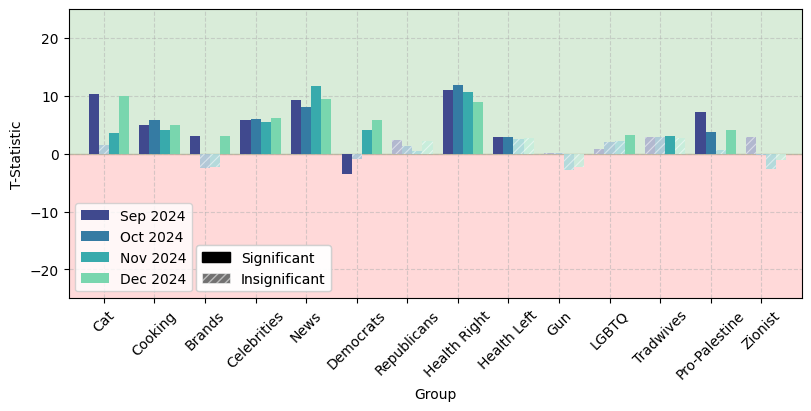

In [ ]:
# make a grouped barchart with different colors for different 'before'


x = np.arange(len(group_order))
width = 0.2
multiplier = 0

# make colormap from seaborn rocket
colors = sns.color_palette("mako", len(before_dates)+1)[1:]

fig, ax = plt.subplots(layout='constrained', figsize = (8,4))
for color, before in zip(colors, before_dates):
  offset = width * multiplier
  df_before = df_ttest[df_ttest['before'] == before].copy()
  rects = ax.bar(x + offset, df_before['tstat'], width, color=color, alpha = 0.75, zorder = 3)
  rects = ax.bar(x + offset, df_before['tstat'], width, edgecolor='white', color = 'white', hatch = '////', alpha = 0.5, hatch_linewidth = 0.8, zorder = 3, linewidth = 0)
  # get tstat if significant, otherwise 0
  df_before['signif_values'] = np.where(df_before['signif'], df_before['tstat'], 0)
  rects = ax.bar(x + offset, df_before['signif_values'], width, color=color, zorder = 3, label=before.strftime("%b %Y"))
  # ax.bar_label(rects, padding=3)
  multiplier += 1

ax.fill_betweenx([-100,0], -100, 100, color='red', alpha=0.15, zorder = 1)
ax.fill_betweenx([0,100], -100, 100, color='green', alpha=0.15, zorder = 1)

ax.set_ylabel('t-statistic')
ax.set_xticks(x + width, [group_titles[x] for x in group_order], rotation = 45)

# set ylim
ax.set_ylim(-25,25)
ax.set_xlim([-0.5,len(group_order)])

# add black square labeled "significant" and black with alpha = 0 and white hatches as "insignificant"
black_patch = mpatches.Patch(color='black', label = 'Significant')
white_patch = mpatches.Patch(color='black', label = 'Insignificant', alpha = 0.5)
white_patch.update({'hatch': '////', 'edgecolor': 'white', 'linewidth': 0.8})

# make separate legend for significant insignificant
handles, labels = ax.get_legend_handles_labels()
l1 = ax.legend(handles, labels, loc = 3)
l2 = ax.legend(handles=[black_patch, white_patch], labels=['Significant', 'Insignificant'], loc=3, bbox_to_anchor=(0.165,0))
ax.add_artist(l1)
ax.add_artist(l2)


# add grid
ax.grid(alpha=0.5, linestyle='--', zorder = 0)

ax.set_xlabel('Group')
ax.set_ylabel('T-Statistic')

plt.savefig(predir+'/figs/ttest_split2.png',bbox_inches='tight', dpi = 800)

(-25.0, 15.0)

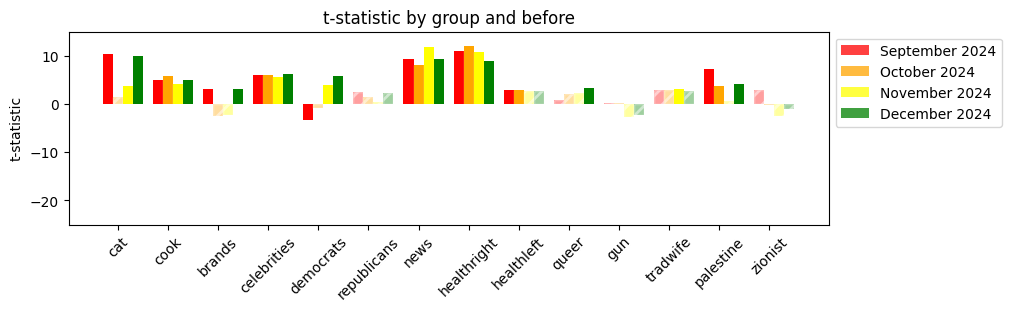

In [ ]:
# make a grouped barchart with different colors for different 'before'


x = np.arange(len(group_order))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize = (10,3))
for color, before in zip(['red','orange','yellow','green'], before_dates):
  offset = width * multiplier
  df_before = df_ttest[df_ttest['before'] == before].copy()
  rects = ax.bar(x + offset, df_before['tstat'], width, label=before.strftime("%B %Y"), color=color, alpha = 0.75)
  rects = ax.bar(x + offset, df_before['tstat'], width, edgecolor='white', color = 'white', hatch = '//', alpha = 0.5, hatch_linewidth = 2)
  # get tstat if significant, otherwise 0
  df_before['signif_values'] = np.where(df_before['signif'], df_before['tstat'], 0)
  rects = ax.bar(x + offset, df_before['signif_values'], width, color=color)
  # ax.bar_label(rects, padding=3)
  multiplier += 1

ax.set_ylabel('t-statistic')
ax.set_title('t-statistic by group and before')
ax.set_xticks(x + width, group_order, rotation = 45)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

plt.ylim(-25,15)
